# **Project:  Computer Vision For Object Detection**

     By Chetan and Tiru
     Professor Edward
     DATA 690
     


  ## Introduction

Object detection is a computer vision technique that allows us to identify and locate objects in an image or video. With this kind of identification and localization, object detection can be used to count objects in a scene and determine and track their precise locations, while accurately labeling them.
Object detection algorithms are being used in applications for fields such as autonomous driving, security cameras, robotics, and almost any application that involves vision–including medical imaging or new trends like Amazon Go cashierless grocery store.

## Dataset for the Project
[Dataset  Udacity Self Driving Car Dataset  fixed-small](https://public.roboflow.com/object-detection/self-driving-car/3)

The dataset contains 97,942 labels across 11 classes(in darknate format we got only 10 classes, Biker is not availabel) and 15,000 images. For this project we used only about 1165 images that are randomly selected from the whole image by keeping the porportions of the lebels. That is, those images have found by calculating the ratio of image labels out of the total image dataset. We used both darknet text format and tensorflow csv format. The list of 10 lebels is given in the code.

 **Note: This model takes data from google drive. To run the note book, first our  input data should be in google drive**

##  Deep learning models: 
Based on Faster R-CNN for object detection, two models are implemented: 


1.   Model 1: Using fasterrcnn_resnet50_fpn and modified it to fit our data set and  analysis objectives.
2.   Model 2: A customized model developed by using the model build by Professor Edward Raff
3. Model 3: efficientdet-d0 from the tensorflow zoo





### Install and Import important Libraries


In [ ]:
# Install dependencies 
!pip install albumentations==0.4.6
!pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

     |████████████████████████████████| 117 kB 6.3 MB/s 
     |████████████████████████████████| 948 kB 31.6 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=8a646c28b3e7c6d62f6d3d44e62c5c05684f0ef2711f25c6ce32754e4a7e60de
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Cloning into 'vision'...
remote: Enumerating objects: 64548, done.
remote: Counting objects: 100% (4328/4328), done.
remote: Compressing objects: 100% (883/883), done.
remote: Total 64548 (delta 3823), reused 3764 (delta 3423), pack-reused

In [ ]:
from zipfile import ZipFile
from PIL import Image
from glob import glob

import re
import shutil
import os
import random
import numpy as np
import pandas as pd
from imageio import imread
import json
import seaborn as sns
from sklearn.metrics import accuracy_score
import tensorflow as tf
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.pyplot import imshow
# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms
from torchvision import transforms as torchtrans 
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import nms

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')
import time

!git clone https://github.com/EdwardRaff/Inside-Deep-Learning.git
%run /content/Inside-Deep-Learning/idlmam.py


Cloning into 'Inside-Deep-Learning'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 34 (delta 10), reused 28 (delta 7), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read and Process the Dataset

In this section, after we downloaded the image dataset from roboflow with Darknet TXT annotation and tensorflow csv annotation format to our drive, then we loaded to colab using glob module. The darknet format is, every image has a corresponding text annotation file where as in tensor flow csv format there is an image file and csv annotation file. We use the tensor flow csv format to get filenames with their corresponding label names, we got this suitable to choose images from the total image dataset based on the labels’ ratio.

In [ ]:
filenames=glob('/content/drive/MyDrive/Deep_Learning/Self Driving Car.v3-fixed-small.darknet/export/**', recursive=False) 
print(len(filenames))

21702


## Get the total number of images for the project

In this section we trimmed the images’ file names to fit with the file names in csv annotation file.

In [ ]:
# Trim the image data filename directory to match up with the annotation data filename
file_name=[]
for i in range(len(filenames)):
    file=filenames[i]
    if file[-4:]== '.jpg':
  
      imagefiles = re.sub(r'\S*/\w+\s\w+.\S*/', '', file)

      file_name.append(imagefiles)
file_name[1]
#len(file_name)

'1478895945176502071_jpg.rf.PPoGYQmMgUktTikYuLdQ.jpg'

In [ ]:
filenames[1] # before trim

'/content/drive/MyDrive/Deep_Learning/Self Driving Car.v3-fixed-small.darknet/export/1478895945176502071_jpg.rf.c8e07b4ec110c4e91a8529cabef2f7d2.txt'

In [ ]:
len(file_name)

10851

### The annotation file in csv format 

In [ ]:
annotation_data= pd.read_csv('/content/drive/MyDrive/Deep_Learning/Self Driving Car.v3-fixed-small.tensorflow /_annotations.csv')
annotation_data.head()

filename  width  ...  xmax ymax
0  1478900859981702684_jpg.rf.6830635c7d919747563...    512  ...   370  331
1  1478900859981702684_jpg.rf.6830635c7d919747563...    512  ...   293  321
2  1478900859981702684_jpg.rf.6830635c7d919747563...    512  ...    13  327
3  1478900859981702684_jpg.rf.6830635c7d919747563...    512  ...   106  304
4  1478900859981702684_jpg.rf.6830635c7d919747563...    512  ...   135  289

[5 rows x 8 columns]

In [ ]:
annotation_data.shape

(194539, 8)

In [ ]:
annotation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194539 entries, 0 to 194538
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  194539 non-null  object
 1   width     194539 non-null  int64 
 2   height    194539 non-null  int64 
 3   class     194539 non-null  object
 4   xmin      194539 non-null  int64 
 5   ymin      194539 non-null  int64 
 6   xmax      194539 non-null  int64 
 7   ymax      194539 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 11.9+ MB


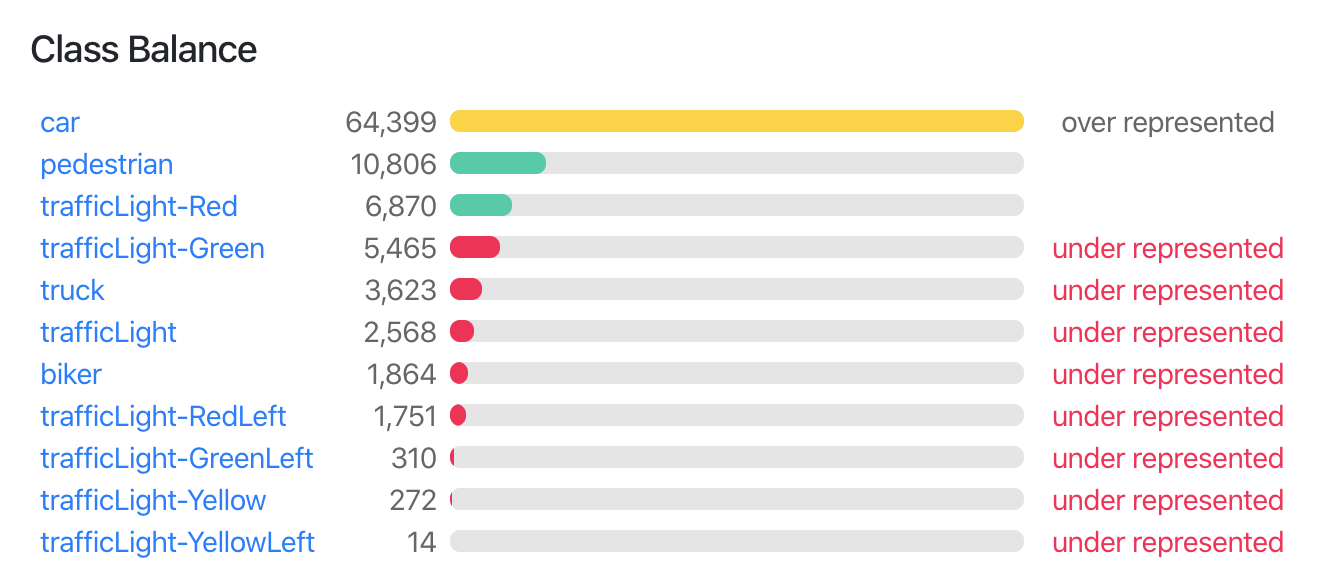

 [source](https://public.roboflow.com/object-detection/self-driving-car) 

The above data summary shows that there are large number of cars, and then pedestrain. Since we keep that ratio in our sampling, we expect that model performs well on prediction car objects. 

In [ ]:
# Get each label's image data from annotation dataframe
car= annotation_data[annotation_data['class']=='car']
pedestrian= annotation_data[annotation_data['class']=='pedestrian']
trafficLight_Red= annotation_data[annotation_data['class']=='trafficLight-Red']
trafficLight_Green= annotation_data[annotation_data['class']=='trafficLight-Green']
truck= annotation_data[annotation_data['class']=='truck']
trafficLight= annotation_data[annotation_data['class']=='trafficLight']
biker= annotation_data[annotation_data['class']=='biker']
trafficLight_RedLeft= annotation_data[annotation_data['class']=='trafficLight-RedLeft']
trafficLight_GreenLeft= annotation_data[annotation_data['class']=='trafficLight-GreenLeft']
trafficLight_Yelow= annotation_data[annotation_data['class']=='trafficLight-Yelow']
trafficLight_YelowLeft= annotation_data[annotation_data['class']=='trafficLight-YelowLeft']


In the above code we got the total images in each label. In the next cell we created two functions, one is to calculate the ratio of each label out of the total image dataset and the second is to get the proportion of total image out of 1000 images for each label. We increased the number of images in random choice to incerase our chance to get 1000 total images for our project.

In [ ]:
# We can modify by those two function to make the code short 
def classratio(total_label, total): # To get class ratios 
   return total_label.shape[0]/ total.shape[0]
def classTotal(label,classratio): #  To get 1000 image labels from annotation dataframe
    return np.random.choice(label['filename'],round(classratio*1000))


# Get the amount of each class data out of 1000 image labels from annotation dataframe

car_labels =classTotal(car,classratio(car,annotation_data))
pedestrian_labels =classTotal(pedestrian,classratio(pedestrian,annotation_data))
trafficLight_Red_labels =classTotal(trafficLight_Red,classratio(trafficLight_Red,annotation_data))
trafficLight_Green_labels =classTotal(trafficLight_Green,classratio(trafficLight_Green,annotation_data))
truck_labels =classTotal(truck,classratio(truck,annotation_data))
trafficLight_labels =classTotal(trafficLight,classratio(trafficLight,annotation_data))
biker_labels =classTotal(biker,classratio(biker,annotation_data))
trafficLight_RedLeft_labels =classTotal(trafficLight_RedLeft,classratio(trafficLight_RedLeft,annotation_data))
trafficLight_GreenLeft_labels =classTotal(trafficLight_GreenLeft,classratio(trafficLight_GreenLeft,annotation_data))
trafficLight_Yelow_labels =classTotal(trafficLight_Yelow,classratio(trafficLight_Yelow,annotation_data))
trafficLight_YelowLeft_labels =classTotal(trafficLight_YelowLeft,classratio(trafficLight_YelowLeft,annotation_data))


In [ ]:
print('The total images in each label out of 1000 images: ','cars_labels:'+ str(car_labels.shape[0]),'pedestrian_labels:'+str(pedestrian_labels.shape[0])\
                                                          ,'trafficLight_Red_labels:'+str(trafficLight_Red_labels.shape[0])\
                                                          ,'trafficLight_Green_labels:'+str( trafficLight_Green_labels.shape[0])
                                                          ,'truck_labels:'+str(truck_labels.shape[0])
                                                          , 'trafficLight_labels'+ str(trafficLight_labels.shape[0]),'biker_labels:'+ str(biker_labels.shape[0])
                                                           ,'trafficLight_RedLeft_labels:'+str(trafficLight_RedLeft_labels.shape[0])
                                                           ,'trafficLight_GreenLeft_labels:'+str(trafficLight_GreenLeft_labels.shape[0])
                                                            , 'trafficLight_Yelow_labels:'+str(trafficLight_Yelow_labels.shape[0])
                                                            ,'trafficLight_YelowLeft_labels:'+str(trafficLight_YelowLeft_labels.shape[0]),sep="\n")
                                                          

The total images in each label out of 1000 images: 
cars_labels:657
pedestrian_labels:110
trafficLight_Red_labels:70
trafficLight_Green_labels:56
truck_labels:37
trafficLight_labels26
biker_labels:19
trafficLight_RedLeft_labels:18
trafficLight_GreenLeft_labels:3
trafficLight_Yelow_labels:0
trafficLight_YelowLeft_labels:0


 Until now we only selected about 1000 images from the annotation file, in the next cell we created a for loop to get filenames in image dataset and found in the selected annotation image filenames will be appended in the list. 

In [ ]:
# Get the image files from image dataset 
all_images=[]
for imag in file_name:
    if imag in car_labels:
        all_images.append(imag)
    elif imag in pedestrian_labels:
         all_images.append(imag)
    elif imag in trafficLight_Red_labels:
         all_images.append(imag)
    elif imag in trafficLight_Green_labels:
         all_images.append(imag)
    elif imag in truck_labels:
         all_images.append(imag)
    elif imag in trafficLight_labels:
         all_images.append(imag)
    elif imag in biker_labels:
         all_images.append(imag)
    elif imag in trafficLight_RedLeft_labels:
         all_images.append(imag)
    elif imag in trafficLight_GreenLeft_labels:
         all_images.append(imag)
    elif imag in trafficLight_Yelow_labels:
          all_images.append(imag)
    elif imag in trafficLight_YelowLeft_labels:
         all_images.append(imag)
   

# put back file path to image filenames
image_path=[]
for img in all_images:
    image_path.append('/content/drive/MyDrive/Deep_Learning/Self Driving Car.v3-fixed-small.darknet/export/' + img )
len(image_path)


1165

In [ ]:
# Get images with their corresponding annotation text files
file_image=[]
for img1 in image_path :
    if img1 in filenames:
       file_image.append(img1)
       file_image.append(img1[:-4] + '.txt')
len(file_image)

2330

In [ ]:
# Save the new image file
for file in file_image:
    shutil.copy(file, '/content/drive/MyDrive/Deep_Learning/self_drivingcar_images')


# Input data loading and processing
### Read the saved image dataset 

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

# defining the files directory and testing directory
files_dir = '/content/drive/MyDrive/Deep_Learning/self_drivingcar_images/'

In [ ]:

# we create a Dataset class which has a __getitem__ function and a __len__ function
class Class2Detect(torch.utils.data.Dataset):

  def __init__(self, files_dir, width, height, transforms=None):
    self.transforms = transforms
    self.files_dir = files_dir
    self.height = height
    self.width = width
    
    # sorting the images for consistency
    # To get images, the extension of the filename is checked to be jpg
    self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-4:]=='.jpg']
    
    # classes: 0 index is reserved for background
    self.classes = [_, 'car','pedestrian','traficLight','traficLight_Green', 'traficLight_GreenLeft', 
                    'trafficLight_Red','traficLight_RedLeft',
                      'trafficLight_Yelow','trafficLight_YelowLeft', 'truck']

  def __getitem__(self, idx):
    img_name = self.imgs[idx]
    image_path = os.path.join(self.files_dir, img_name)

    # reading the images and converting them to correct size and color    
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
    # diving by 255
    img_res /= 255.0
    
    # annotation file
    annot_filename = img_name[:-4] + '.txt'
    annot_file_path = os.path.join(self.files_dir, annot_filename)
    
    boxes = []
    labels =[] 
  
    
    # cv2 image gives size as height x width
    wt = img.shape[1]
    ht = img.shape[0]
    # for i in class_labels:
  
    # box coordinates for txt files are extracted and corrected for image size given
    with open(annot_file_path) as f:
      for line in f:
        
        
        parsed = [float(x) for x in line.split(' ')]
        
        x_center = parsed[1]
        y_center = parsed[2]
        box_wt = parsed[3]
        box_ht = parsed[4]
      # The annotation is in [x_center, y_center, wt,ht ] from, we should Convert it to  [xmin, ymin, xmax, ymax]
        xmin = x_center - box_wt/2
        xmax = x_center + box_wt/2
        ymin = y_center - box_ht/2
        ymax = y_center + box_ht/2
        
        xmin_corr = int(xmin*self.width)
        xmax_corr = int(xmax*self.width)
        ymin_corr = int(ymin*self.height)
        ymax_corr = int(ymax*self.height)
        
        boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        labels.append(parsed[0])


    # convert boxes into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    # getting the areas of the boxes
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    # suppose all instances are not crowd
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

    labels = torch.as_tensor(labels, dtype=torch.int64)

    name=self.classes

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["area"] = area
    target["iscrowd"] = iscrowd
    image_id = torch.tensor([idx])
    target["image_id"] = image_id

    if self.transforms:
      sample = self.transforms(image = img_res,
                                bboxes = target['boxes'],
                                labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])

      
        
    return img_res, target

  def __len__(self):
    return len(self.imgs)


name=[_, 'car','pedestrian','traficLight','traficLight_Green', 'traficLight_GreenLeft', 
                    'trafficLight_Red','traficLight_RedLeft',
                      'trafficLight_Yelow','trafficLight_YelowLeft', 'truck']


In [ ]:
# check dataset
dataset = Class2Detect(files_dir, 512, 512)
print('Length of dataset:', len(dataset), '\n')
# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[1]
print('Image shape:', img.shape)
print('Label example:', target)


Length of dataset: 1165 

Image shape: (512, 512, 3)
Label example: {'boxes': tensor([[215., 247., 221., 254.],
        [185., 249., 190., 255.],
        [ 85., 247.,  89., 262.],
        [146., 241., 163., 268.],
        [154., 234., 173., 260.],
        [190., 240., 205., 260.]]), 'labels': tensor([ 1,  1,  2,  1, 10,  1]), 'area': tensor([ 42.,  30.,  60., 459., 494., 300.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'image_id': tensor([1])}


In [ ]:
print (min( target["labels"]), max( target["labels"]))

tensor(1) tensor(10)


In [ ]:
print(name)

 ## Data visualization to check if it is properly loaded.

In [ ]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(7,7)
  a.imshow(img)
  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 1.5,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)
  plt.show()
    


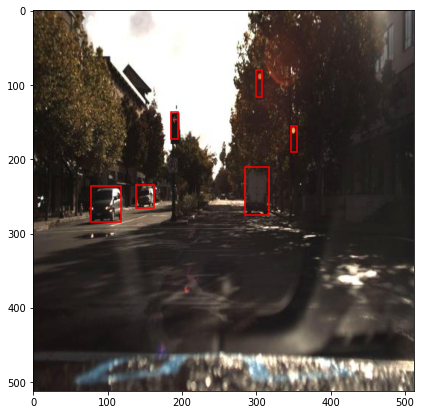

In [ ]:
# plotting the image with bboxes. 
img, target= dataset[30]
plot_img_bbox(img, target)

#  Helper Functions for data visualization and others


In [ ]:
# Agummentation

# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
  if train:
    return A.Compose(
      [
        A.HorizontalFlip(0.5),
        # ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return A.Compose(
      [ToTensorV2(p=1.0)],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

In [ ]:
# A function  to detect and draw the boxes
def plotDetection(ax, abs_pos, label=None):
    """
    ax: the matpllib axis to add this plot to
    abs_pos: the positions of the bounding box
    label: the label of the prediction to add
    """
    x1, y1, x2, y2 = abs_pos
    #make a rectangle for the bounding box
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1.5,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    #add the label if given
    if label is not None:
        plt.text(x1+0.5, y1, label, color='black', bbox=dict(facecolor='white', edgecolor='white', pad=1.0))
    
    return 

In [ ]:
 # Function for predictions and to implement NMS
def showPreds(img, pred, iou_max_overlap=0.5, min_score=0.05, label_names=None):
    """
    img: the original image object detection was performed on
    pred: the output dictionary from FasterRCNN for evaluation on img
    iou_max_overlap: the iou threshold at which non-maximum suppression will be performed
    min_score: the minimum RPN network score to consider an object
    """
    fig,ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (7,7)
    img = img.cpu().numpy()
    if img.shape[0] == 1:
        ax.imshow(img[0,:])
    else:
        ax.imshow(np.moveaxis(img, 0, 2))
    boxes = pred['boxes'].cpu()
    labels = pred['labels'].cpu()
    scores = pred['scores'].cpu()
    
    selected = nms(boxes, scores, iou_max_overlap).cpu().numpy()
    
    for i in selected:
        if scores[i].item() > min_score:
            if label_names is None:
                label = str(labels[i].item())
            else:
                label = label_names[labels[i].item()]
            plotDetection(ax, boxes[i].cpu().numpy(), label=label)
    
    plt.show()
    
    


# Impementing  Deep Learning Models 



In [ ]:
#How many channels are in the input?
C = 3
#How many classes are there?
classes = 11
#How many filters in our backbone
n_filters = 32

# How many epochs the model run 
num_epochs = 10


# Model 1: Using fasterrcnn_resnet50_fpn: We used both the pretrained and not  pretrained

In [ ]:
train_data = Class2Detect(files_dir, 512, 512,transforms=get_transform(train=True))
test_data = Class2Detect(files_dir, 512, 512, transforms=get_transform(train=False))
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(train_data)).tolist()
# train test split
test_split = 0.2
tsize = int(len(train_data)*test_split)
train_data= torch.utils.data.Subset(train_data, indices[:-tsize])
test_data = torch.utils.data.Subset(test_data, indices[-tsize:])

# define training and validation data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=10, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=10, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trainedand and the untrained 
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [ ]:
# Train the model on gpu if selected.

num_classes = classes

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# The learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

## Training model 1

In [ ]:
# training for 10 epochs

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
evaluate(model,test_loader, device=device)

Epoch: [0]  [ 0/94]  eta: 0:18:59  lr: 0.000059  loss: 3.2396 (3.2396)  loss_classifier: 2.3285 (2.3285)  loss_box_reg: 0.7250 (0.7250)  loss_objectness: 0.0898 (0.0898)  loss_rpn_box_reg: 0.0963 (0.0963)  time: 12.1183  data: 8.0925  max mem: 7157
Epoch: [0]  [50/94]  eta: 0:01:16  lr: 0.002744  loss: 0.9722 (1.4934)  loss_classifier: 0.3254 (0.7344)  loss_box_reg: 0.5038 (0.6245)  loss_objectness: 0.0552 (0.0741)  loss_rpn_box_reg: 0.0482 (0.0603)  time: 1.1322  data: 0.0352  max mem: 7423
Epoch: [0]  [93/94]  eta: 0:00:01  lr: 0.005000  loss: 0.8142 (1.1974)  loss_classifier: 0.2882 (0.5352)  loss_box_reg: 0.4444 (0.5482)  loss_objectness: 0.0372 (0.0590)  loss_rpn_box_reg: 0.0400 (0.0550)  time: 1.0849  data: 0.0321  max mem: 7423
Epoch: [0] Total time: 0:02:16 (1.4477 s / it)
Epoch: [1]  [ 0/94]  eta: 0:02:36  lr: 0.005000  loss: 0.8358 (0.8358)  loss_classifier: 0.3017 (0.3017)  loss_box_reg: 0.4618 (0.4618)  loss_objectness: 0.0274 (0.0274)  loss_rpn_box_reg: 0.0449 (0.0449)  ti

## Comparison: 
For model 1, We also used the untrained model and trained it with our data.  The model perpformance is  as good as the preterained one.     
Precesion and recall resutsls when pretrained=False are given below.

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.219 

 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.052

 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.066

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.094

 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.275

 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.060

 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.156

 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.178

 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.162

 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.241

 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.358

# Predictions  and testing using  model 1


In this section we can see how our model performed on the data it has never seen before, test data. As expected the number of bounding boxes from prediction are larger than the expected bounding boxes.


 ##  Non Max Suppression (For function showPreds, this  is not be used)
  The model predicts a lot of bounding boxes per image, to take out the overlapping ones, We  use Non Max Suppression. Torchvision provides us a utility to apply nms to our predictions.

  This function is rarely used for our comparision.

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')


In [ ]:
# pick one image from the test set
img, target = test_data[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  43
real #boxes:  12


EXPECTED OUTPUT


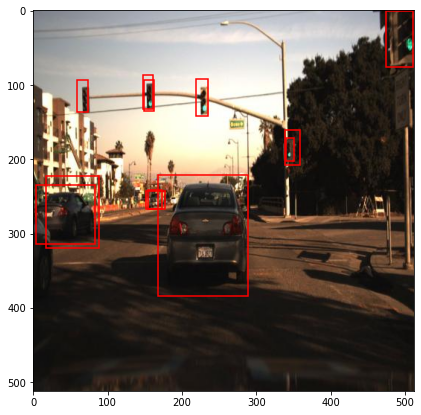

MODEL OUTPUT


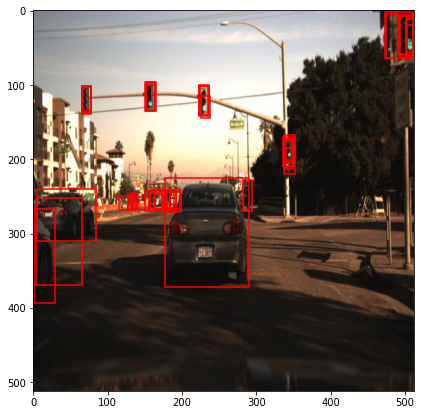

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)



When we applied nms function to our model's prediction, the output looked much better.

NMS APPLIED MODEL OUTPUT


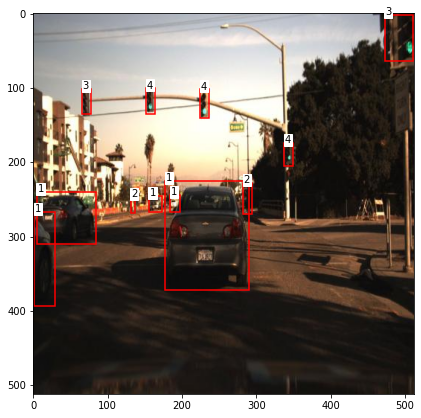

In [ ]:

print('NMS APPLIED MODEL OUTPUT')
showPreds(img,prediction, iou_max_overlap=0.15, min_score=0.15)

Using the showPreds function we could get label the classes.

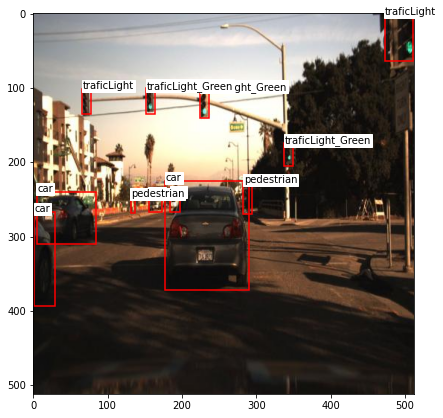

In [ ]:
showPreds(img,prediction, iou_max_overlap=0.15, min_score=0.15, label_names=name)

In [ ]:
#Testing the model 2

test_dataset = Class2Detect(files_dir, 512, 512,transforms=get_transform(train=False))
# pick one image from the test set
img, target = test_dataset[150]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  48
real #boxes:  18


EXPECTED OUTPUT



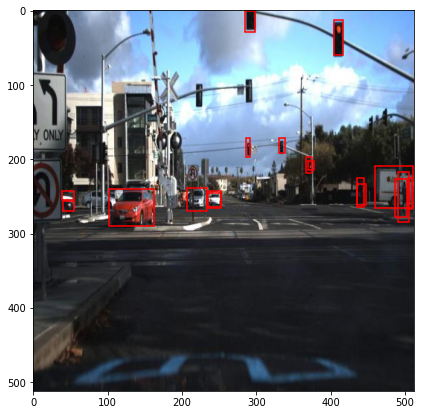

MODEL OUTPUT


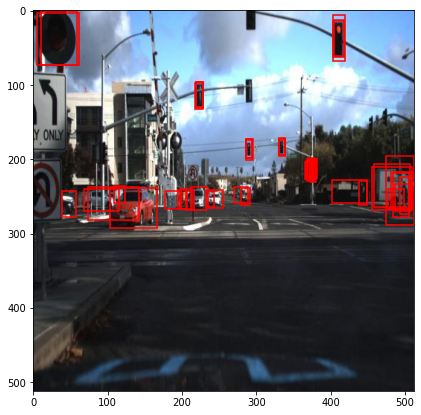

NMS APPLIED MODEL OUTPUT


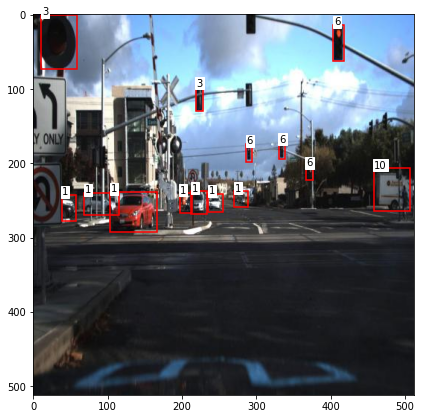

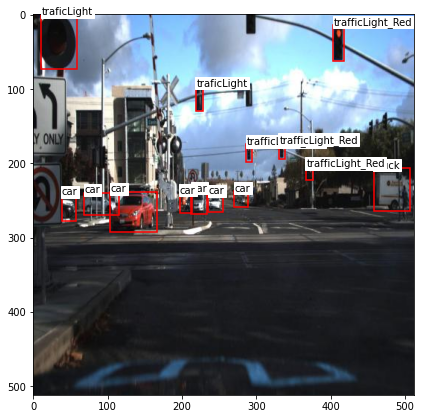

In [ ]:
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)


print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)


print('NMS APPLIED MODEL OUTPUT')

showPreds(img,prediction, iou_max_overlap=0.15, min_score=0.15)

showPreds(img,prediction, iou_max_overlap=0.15, min_score=0.15, label_names=name)

#  Model 2: Customized model by using the model build by   Professor Edward Raff

In [ ]:
#Define our helper function that creates a hidden layer for a CNN
def cnnLayer(in_filters, out_filters, kernel_size=3):
    """
    in_filters: how many channels are in the input to this layer
    out_filters: how many channels should this layer output
    kernel_size: how large should the filters of this layer be
    """
    padding = kernel_size//2
    return nn.Sequential(
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.BatchNorm2d(out_filters),
        nn.LeakyReLU(0.06), # leak_rate = 0.1 #How much I want the LeakyReLU to "leak" by. Anything in [0.01, 0.3] is fine, default = 0.01
    )


In [ ]:
backbone = nn.Sequential(
    cnnLayer(C, n_filters),    
    cnnLayer(n_filters, n_filters),
    cnnLayer(n_filters, n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters),
    cnnLayer(4*n_filters, 4*n_filters),
)
#Let Faster RCNN know exactly how many output channels to expect
backbone.out_channels = n_filters*4

In [ ]:
#anchor_generator = AnchorGenerator(sizes=((32,64),), aspect_ratios=((0.5,1.0),))
                                 

anchor_generator = AnchorGenerator(sizes=((16,32),), aspect_ratios=((0.5,1.0),))

#faster, we are telling PyTorch to look for only square images that are 32 x 32 in size
#Tell PyTorch to use the final output of the backbone as the featuremap (['0']), use
#adaptive pooling down to a 7x7 grid (output_size=7)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

#Now we can create the FasterRCNN object. We give it the backbone network, number of classes, min & max size to process images at 
# (RPN) and RoI objects

model = FasterRCNN(backbone, num_classes=11, image_mean = [0.5], image_std = [0.229],
min_size=100, max_size=512, rpn_anchor_generator=anchor_generator,
box_roi_pool=roi_pooler)

In [ ]:
train_data = Class2Detect(files_dir, 512, 512,transforms=get_transform(train=True))
test_data = Class2Detect(files_dir, 512, 512, transforms=get_transform(train=False))
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(train_data)).tolist()
# train test split
test_split = 0.2
tsize = int(len(train_data)*test_split)
train_data= torch.utils.data.Subset(train_data, indices[:-tsize])
test_data = torch.utils.data.Subset(test_data, indices[-tsize:])

def collate_fn(batch):
    """
    batch is going to contain a python list of objects. In our case, our data loader returns (Tensor, Dict) pairs
    The FasterRCNN algorithm wants a List[Tensors] and a List[Dict]. So we will use this function to convert the 
    batch of data into the form we want, and then give it to the Dataloader to use
    """
    imgs = []
    labels = []
    for img, label in batch:
        imgs.append(img)
        labels.append(label)
    return imgs, labels

train_loader = torch.utils.data.DataLoader(
  train_data,
  batch_size=5,  # we modified this value 
  shuffle=True,
  collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(
  test_data,
  batch_size=1,
  shuffle=False,
  collate_fn=collate_fn)

## Training model 2

In [ ]:
num_epochs = 15 # this model works fine for this epoch number, increasing from this makes the prediction good but not very significant 

model = model.train()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters())

for epoch in tqdm(range(num_epochs), desc="Epoch", disable=False):
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        optimizer.zero_grad()
        losses = model(inputs, labels)
        loss = 0
        for partial_loss in losses.values():
            loss += partial_loss
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
evaluate(model,test_loader, device=device)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/187 [00:00<?, ?it/s]

creating index...
index created!
Test:  [  0/233]  eta: 0:00:10  model_time: 0.0170 (0.0170)  evaluator_time: 0.0152 (0.0152)  time: 0.0451  data: 0.0118  max mem: 7423
Test:  [100/233]  eta: 0:00:04  model_time: 0.0126 (0.0130)  evaluator_time: 0.0087 (0.0085)  time: 0.0326  data: 0.0099  max mem: 7423
Test:  [200/233]  eta: 0:00:01  model_time: 0.0128 (0.0129)  evaluator_time: 0.0077 (0.0082)  time: 0.0334  data: 0.0107  max mem: 7423
Test:  [232/233]  eta: 0:00:00  model_time: 0.0129 (0.0130)  evaluator_time: 0.0069 (0.0084)  time: 0.0336  data: 0.0102  max mem: 7423
Test: Total time: 0:00:07 (0.0328 s / it)
Averaged stats: model_time: 0.0129 (0.0130)  evaluator_time: 0.0069 (0.0084)
Accumulating evaluation results...
DONE (t=0.24s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.

# Predictions on Test dataset using  model 2


In [ ]:
# pick one image from the test set
img, target = test_data[31]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  54
real #boxes:  13


EXPECTED OUTPUT


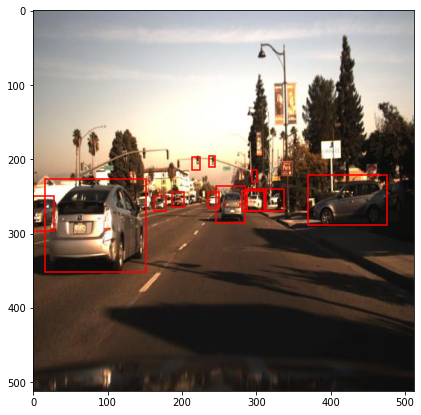

MODEL OUTPUT


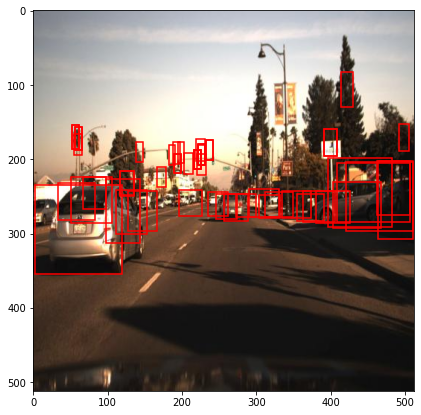

NMS APPLIED MODEL OUTPUT


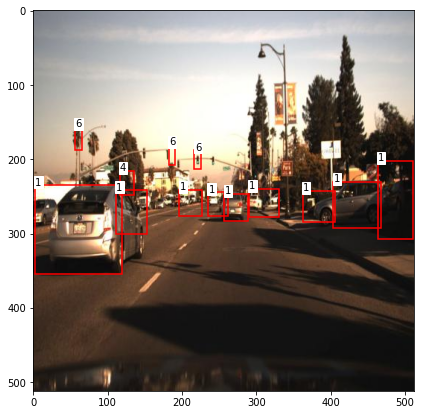

NMS APPLIED MODEL OUTPUT With Names


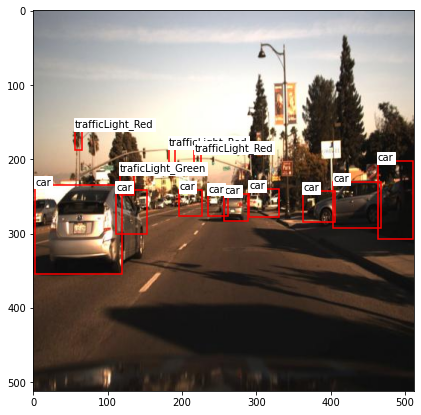

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)


print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)


print('NMS APPLIED MODEL OUTPUT')


showPreds(img,prediction, iou_max_overlap=0.15, min_score=0.15)

print('NMS APPLIED MODEL OUTPUT With Names')
showPreds(img,prediction, iou_max_overlap=0.15, min_score=0.15, label_names=name)

In [ ]:
#Testing the model 2

test_dataset = Class2Detect(files_dir, 512, 512,transforms=get_transform(train=False))
# pick one image from the test set
img, target = test_dataset[150]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  57
real #boxes:  18


EXPECTED OUTPUT



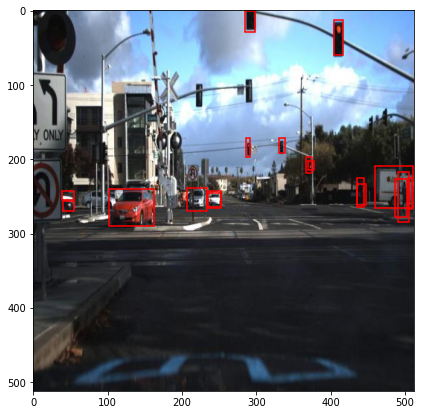

MODEL OUTPUT


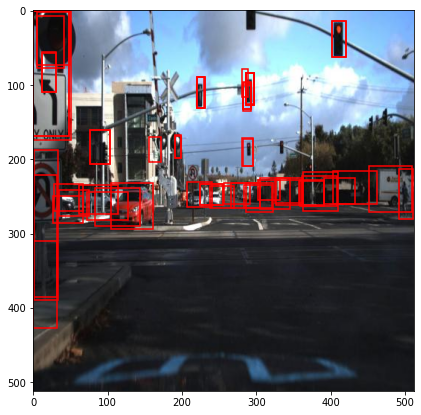

NMS APPLIED MODEL OUTPUT


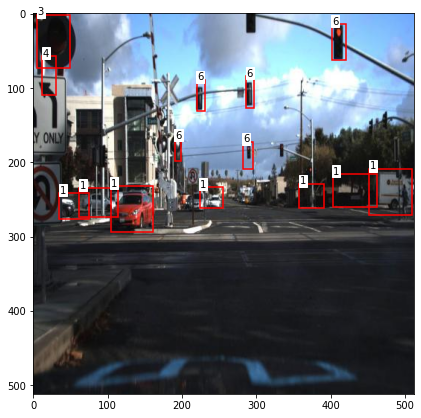

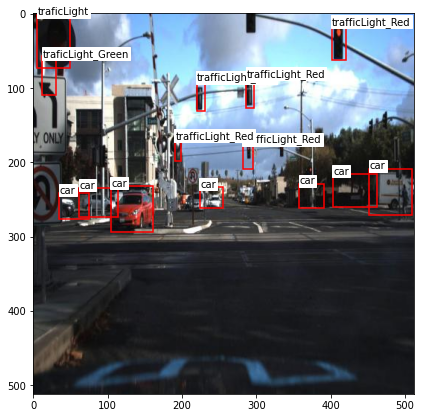

In [ ]:
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)


print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)


print('NMS APPLIED MODEL OUTPUT')

showPreds(img,prediction, iou_max_overlap=0.15, min_score=0.15)

showPreds(img,prediction, iou_max_overlap=0.15, min_score=0.15, label_names=name)

#Model 3


Referenced from [Matthew stone](https://www.youtube.com/watch?v=_rXaBamB8C0&list=PLjEV9e8qfwa-Gaa6pi1rzifaqJaRBW8XU&index=1) and [roboflow models](https://colab.research.google.com/drive/1U3fkRu6-hwjk7wWIpg-iylL2u5T9t7rr#scrollTo=yhzxsJb3dpWq):

Results from the model "efficientdet-d0" from a TensorFlow 2 Detection Model Zoo 

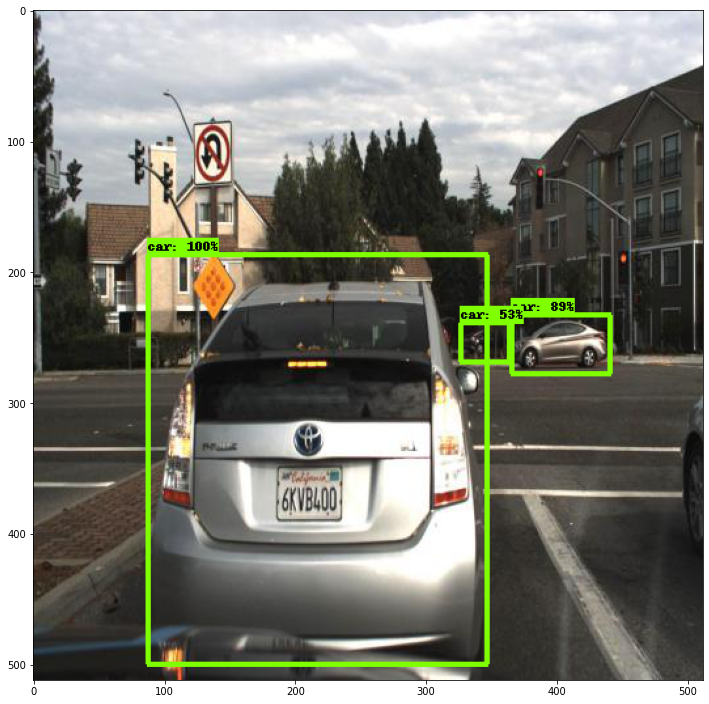

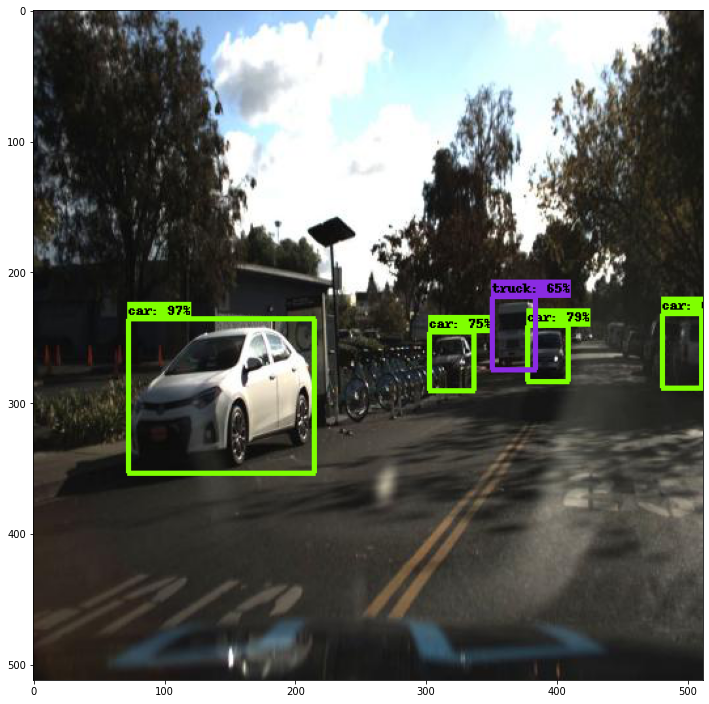

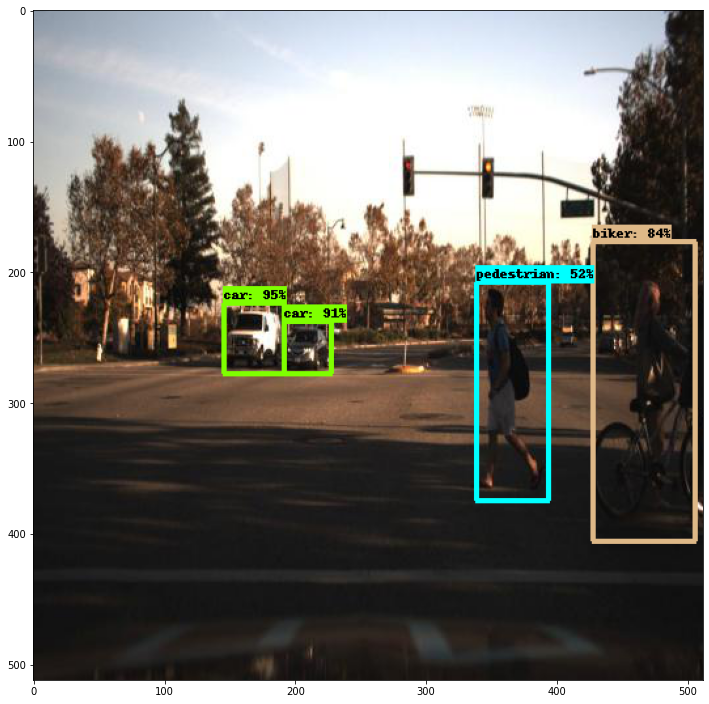

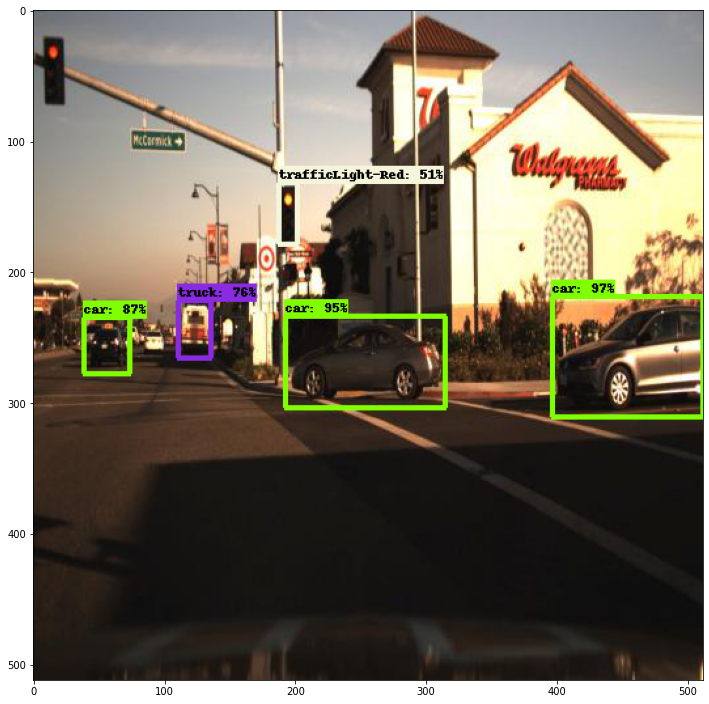

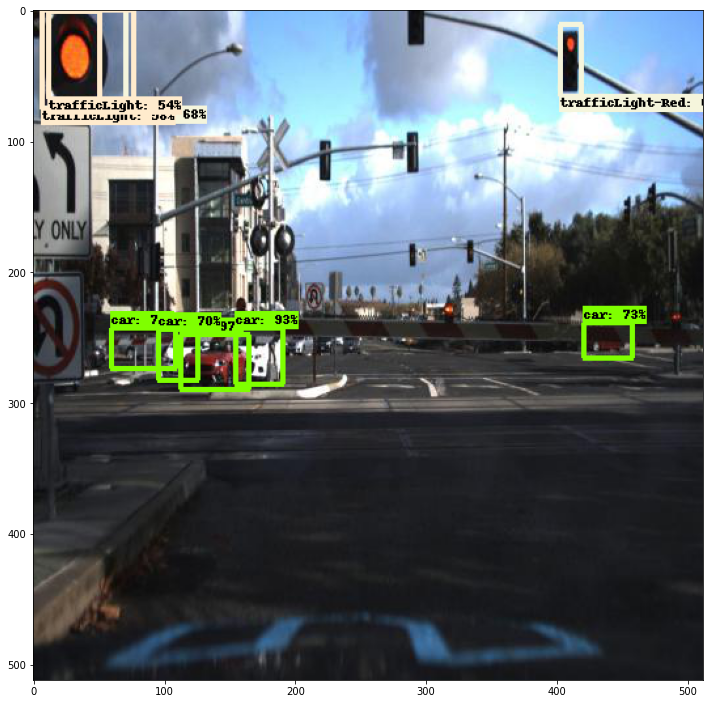

#Losses during the training of Model

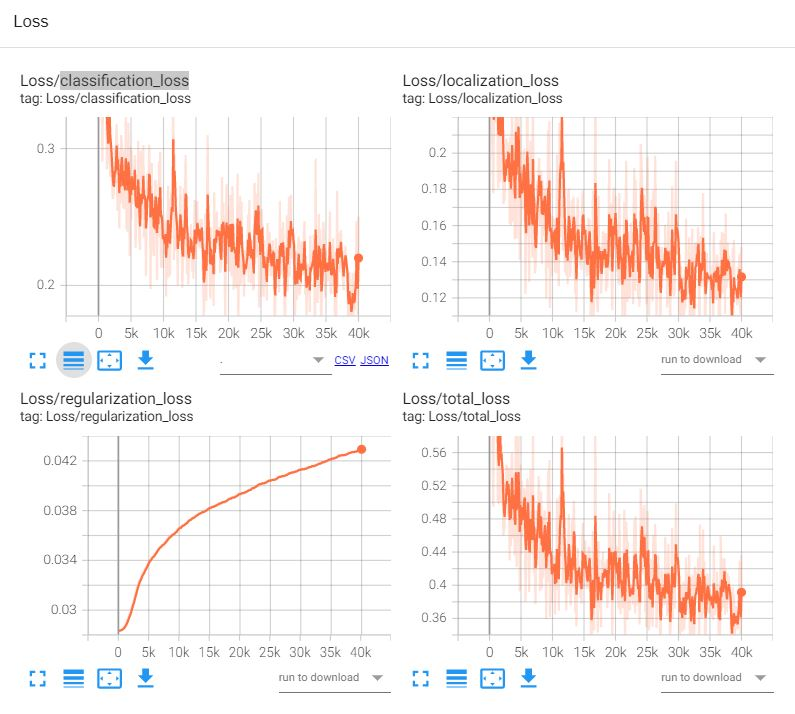

#Training and Steps/sec

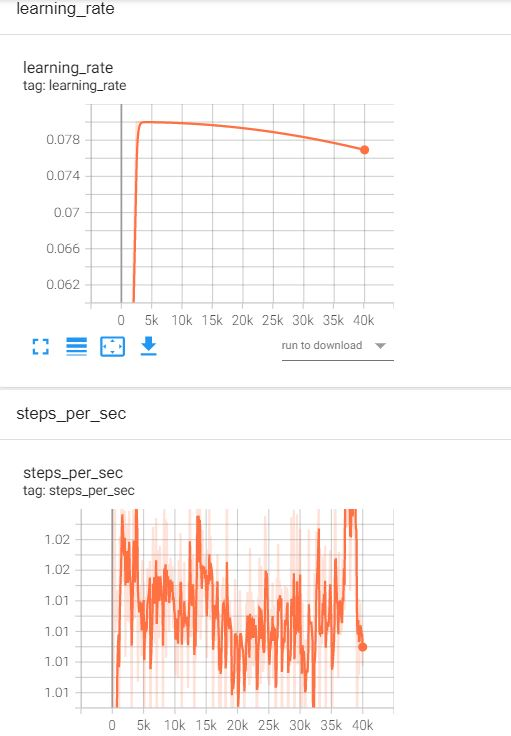

# Summary:

*   Both Model 1 and Model 2 performed well, particularly Model 1 predicted every object with minimal error. The average precision values confirm this too. 
*   Both models detected large objects in a much better way than smaller objects. Smaller objects are harder to detect because they are represented by a smaller area on the image.  The average precision values confirm this too. 
*   Model 1 is better on prediction and as small as 10 epochs are enough, but model 2 is faster and it needs more epochs. 
*   Clearly, increasing the size of the data (using large number of images) would increase the accuracy and precision of model prediction, but it is time consuming.   
*   We changed AnchorGenerator and aspect ratios by using set of combinations of values from the following. Although there is no big significant effect for our data, the model prediction varies: Some sets are good for small objects, some sets are good for large objects. 
*   Since Our data have very small objects (e.g. traffic lights) and large objects (Trucks), It is not easy to get a perfect set of parameters that works  better for all objects.
*   The distance that the object is located also affects the model predictions. The truck object located very far when the image was taken may look like a dark tall object. 
*   Predicitons on Traffic lights is  complex since they have similarities other background objects and the model cannot ignore the back of the traffic lights located the otehr side of the road.  

*    In general, We evaluated the models (particularly model 2) by varying the values of set of parameters, such as leak rate, batch size, anchor generator, aspect ratios, minim and maximus sizes of images, and mean and standard values of image. Some of the changes improve the performance of the model. 







#Future Work



*  We plan on building the model which works on the vedio as an input, and also the live interaction.


* We tried Evaluating Object detection models using mean Average precision( which compares the target box and the predicted box in our model and returns the score, higher the score better the model).

* We want to compare the mAp between the models we created and the tensor model which was trained on all the images


* And also working with different datasets to check if the models works fine for other applications in to detect drowsiness of a driver, people wearning mask in public places, healthcare etc.



# References
1. Deep Learning Classes 
2. Inside Deep Learning Book
3.  Professor Edward Raff Github codes on Deep Learning
4. https://www.kaggle.com/yerramvarun/fine-tuning-faster-rcnn-using-pytorch/notebook
5. https://www.fritz.ai/object-detection/#part-basics
6. 
https://colab.research.google.com/drive/1U3fkRu6-hwjk7wWIpg-iylL2u5T9t7rr#scrollTo=yhzxsJb3dpWq
7.mathew stone:https://www.youtube.com/watch?v=_rXaBamB8C0&list=PLjEV9e8qfwa-Gaa6pi1rzifaqJaRBW8XU&index=1  
8. https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md